In [23]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import scipy as sp
import pandas as pd
import itertools
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

In [24]:
pos = [5, 8.5, 15, 21.5]
combinations = list(itertools.product(pos, repeat=4))
df = pd.DataFrame(combinations, columns=["pos1", "pos2", "pos3", "pos4"])

# Add index columns
df["pos1_idx"] = df["pos1"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})
df["pos2_idx"] = df["pos2"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})
df["pos3_idx"] = df["pos3"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})
df["pos4_idx"] = df["pos4"].map({5: 1, 8.5: 2, 15: 3, 21.5: 4})

df["CM_x"] = df["pos1"] - df["pos3"]
df["CM_y"] = df["pos4"] - df["pos2"]
df["CM_r"] = np.sqrt(df["CM_x"]**2 + df["CM_y"]**2)
df["CM_phi"] = np.arctan2(df["CM_y"], df["CM_x"])

df["MoI"] = (df["pos1"]**2 + df["pos2"]**2 + df["pos3"]**2 + df["pos4"]**2)/4


# scale MoI and CM_r to -1 1
df["MoI"] = 2 * (df["MoI"] - df["MoI"].min()) / (df["MoI"].max() - df["MoI"].min()) - 1
df["CM_r"] = 2 * (df["CM_r"] - df["CM_r"].min()) / (df["CM_r"].max() - df["CM_r"].min()) - 1


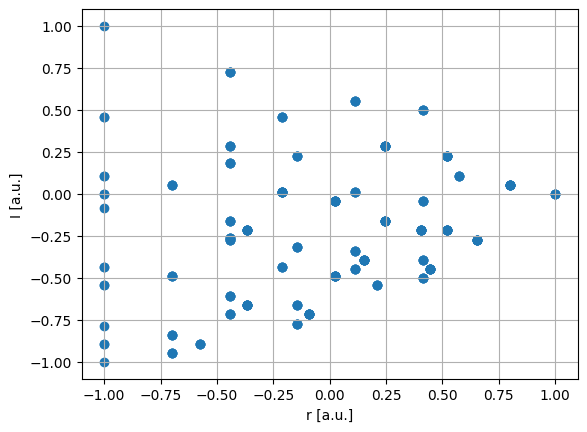

In [25]:
plt.figure()
plt.scatter(df["CM_r"], df["MoI"])
plt.xlabel("r [a.u.]")
plt.ylabel("I [a.u.]")
# plt.title("Moment of Inertia vs Center of Mass Radius")
plt.grid()
plt.savefig("MoI_vs_CMr.png")
plt.show()

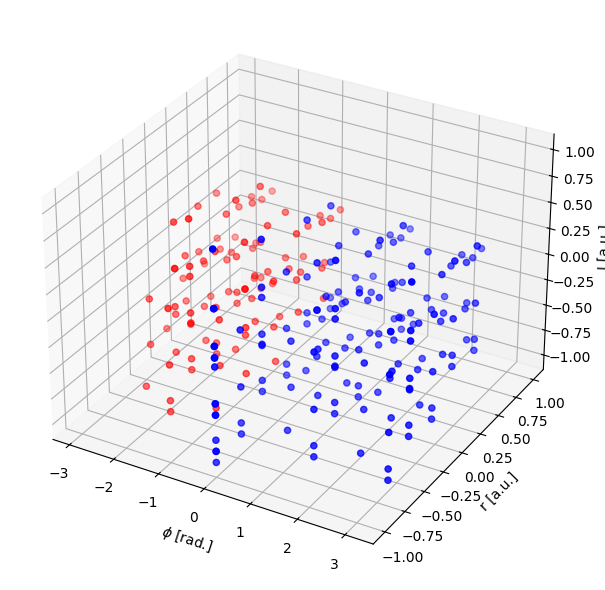

In [26]:
# Assuming your dataframe is named df
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
color = np.where(df["CM_phi"]>=0, "blue", "red")

ax.scatter(df["CM_phi"], df["CM_r"], df["MoI"], c=color, marker='o')

# Labels
ax.set_ylabel("r [a.u.]")
ax.set_xlabel("$\\phi$ [rad.]")
ax.set_zlabel("I [a.u.]")
# ax.set_title("3D Scatter Plot of CM_r, CM_phi, and MoI")
plt.tight_layout()
plt.savefig("3D_scatter_CMr_CMphi_MoI.png")
plt.show()

Best D-optimal design points:
        CM_r       MoI
0  -0.700015 -0.945969
2   0.414214 -0.500000
29  0.414214  0.500000
44 -0.442886  0.728702


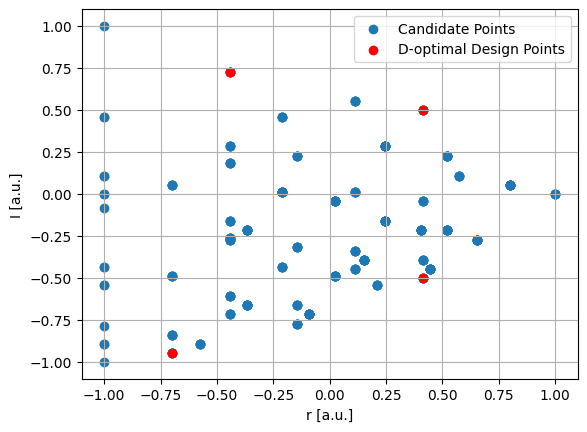

In [27]:
def d_optimal_design_vectorized(df, n_points=4, model='interaction'):

    # ---- Build model matrix ----
    if model == 'linear':
        X = np.column_stack([np.ones(len(df)), df['CM_r'], df['MoI']])
    elif model == 'interaction':
        X = np.column_stack([np.ones(len(df)), df['CM_r'], df['MoI'], df['MoI'] * df['CM_r']])
    elif model == 'quadratic':
        X = np.column_stack([np.ones(len(df)), df['CM_r'], df['MoI'],  df['MoI'] * df['CM_r'], df['CM_r']**2, df['MoI']**2])
    else:
        raise ValueError("model must be 'linear' or 'interaction'")

    n_candidates = len(df)

    # ---- Generate all combinations of n_points from the candidate set ----
    combos = np.array(list(itertools.combinations(range(n_candidates), n_points)))

    # ---- Vectorized determinant computation ----
    # Stack the X matrices for each subset: shape (n_samples, n_points, n_features)
    X_sub = X[combos]  # advanced indexing

    # Compute X'X for each subset (batched matmul)
    XtX = np.einsum('sni,snj->sij', X_sub, X_sub)

    # Compute determinants for all subsets
    dets = np.linalg.det(XtX)

    # ---- Select best subset ----
    best_idx = np.argmax(dets)
    best_det = dets[best_idx]
    best_points = df.iloc[combos[best_idx]]

    return best_points, combos[best_idx], best_det

# pick all unique combinations of r_CM and I in df
df_2D = df[['CM_r', 'MoI']].drop_duplicates().reset_index(drop=True)
# only take points with r>3
df_2D = df_2D[df_2D['CM_r'] > -1].reset_index(drop=True)

best_points, best_indices, best_det = d_optimal_design_vectorized(df_2D, n_points=4, model='interaction')
print("Best D-optimal design points:")
print(best_points)

df['isBest'] = False
for _, row in best_points.iterrows():
    mask = (np.isclose(df['CM_r'], row['CM_r'], atol=1e-6)) & (np.isclose(df['MoI'], row['MoI'], atol=1e-6))
    df.loc[mask, 'isBest'] = True

plt.figure()
plt.scatter(df["CM_r"], df["MoI"], label="Candidate Points")
plt.scatter(best_points["CM_r"], best_points["MoI"], color='red', label="D-optimal Design Points")
plt.xlabel("r [a.u.]")
plt.ylabel("I [a.u.]")
plt.legend()
plt.grid()
plt.show()

In [29]:
# Create an interactive 3D scatter plot with hover information
fig = px.scatter_3d(df, 
                    x='CM_r', 
                    y='CM_phi', 
                    z='MoI',
                    color='isBest',
                    color_discrete_map={False: 'blue', True: 'red'},
                    hover_data=['pos1', 'pos2', 'pos3', 'pos4'],
                    title='Domain',
                    labels={
                        'CM_r': 'Center of Mass Radius',
                        'CM_phi': 'Center of Mass Angle (radians)',
                        'MoI': 'Moment of Inertia'
                    })

# Customize the appearance
fig.update_traces(marker=dict(size=5, opacity=0.8))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='CM_r',
        yaxis_title='CM_phi',
        zaxis_title='MoI',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=800,
    height=600,
    showlegend=False
)

fig.show()

In [ ]:
df_experiment = df[df['isBest']].reset_index(drop=True)
df_experiment = df_experiment[df_experiment["CM_phi"]>0].reset_index(drop=True)
df_experiment_shuffled = df_experiment.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_experiment_shuffled)

# save only pos1_idx, pos2_idx, pos3_idx, pos4_idx to csv
df_experiment_shuffled[["pos1_idx", "pos2_idx", "pos3_idx", "pos4_idx", "CM_phi"]].to_csv("data.csv", index=False)

   pos1  pos2  pos3  pos4  pos1_idx  pos2_idx  pos3_idx  pos4_idx  CM_x  CM_y  \
0   5.0   5.0   5.0  21.5         1         1         1         4   0.0  16.5   
1  15.0  21.5  21.5  21.5         3         4         4         4  -6.5   0.0   
2   5.0   5.0   5.0   8.5         1         1         1         2   0.0   3.5   
3  21.5  15.0  21.5  21.5         4         3         4         4   0.0   6.5   
4   5.0   5.0   8.5   5.0         1         1         2         1  -3.5   0.0   
5   5.0  21.5  21.5  21.5         1         4         4         4 -16.5   0.0   
6   5.0   5.0  21.5   5.0         1         1         4         1 -16.5   0.0   
7  21.5   5.0  21.5  21.5         4         1         4         4   0.0  16.5   

       CM_r    CM_phi       MoI  isBest  
0  0.414214  1.570796 -0.500000    True  
1 -0.442886  3.141593  0.728702    True  
2 -0.700015  1.570796 -0.945969    True  
3 -0.442886  1.570796  0.728702    True  
4 -0.700015  3.141593 -0.945969    True  
5  0.414214  3.141